# Decoherence of a Cat State

We start with a superposition that is simultaneously in two macroscopically distinct states. Coupling to a simple environment destroys the interference terms in the density matrix, leaving a classical statistical mixture. This notebook uses the Lindblad tools from `wavefunction_now` to show how classical probabilities emerge from a strictly present-time quantum model.

## 1. Imports and plotting style

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from wavefunction_now.lindblad import LindbladSimulator, QuantumTrajectorySimulator
from wavefunction_now.measurement import density_matrix_probabilities

plt.style.use('ggplot')
np.set_printoptions(suppress=True, precision=3)

## 2. Define the cat state (two macroscopically distinct branches)

We model a `cat` as a qubit that is either in the `|0⟩` (alive) or `|1⟩` (not alive) state. The initial wave function is the coherent superposition:

$$|\Psi_	ext{cat}\rangle = rac{|0\rangle + |1\rangle}{\sqrt{2}}.$$

We convert it to a density matrix so we can track interference vs classical probabilities.

In [2]:
ket0 = np.array([1.0, 0.0], dtype=complex)
ket1 = np.array([0.0, 1.0], dtype=complex)
cat_state = (ket0 + ket1) / np.sqrt(2)
rho_cat = np.outer(cat_state, cat_state.conj())
rho_cat

array([[0.5+0.j, 0.5+0.j],
       [0.5+0.j, 0.5+0.j]])

The off-diagonal element $\ho_{01}=0.5$ encodes the phase coherence that supports interference between the two branches.

## 3. Lindblad evolution with dephasing noise

We model the environment as a dephasing channel generated by the collapse operator $L=\sqrt{\gamma}\,\sigma_z$. This keeps the populations fixed but suppresses coherence at rate $2\gamma$.

In [3]:
gamma = 1.2
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
collapse_ops = (np.sqrt(gamma) * sigma_z,)
hamiltonian = np.zeros((2, 2), dtype=complex)

simulator = LindbladSimulator(hamiltonian=hamiltonian, collapse_operators=collapse_ops)
times = np.linspace(0.0, 3.0, 301)
rho_evolution = simulator.evolve(rho_cat, times)
coherence = np.abs(rho_evolution[:, 0, 1])
pop0 = np.real(rho_evolution[:, 0, 0])
pop1 = np.real(rho_evolution[:, 1, 1])

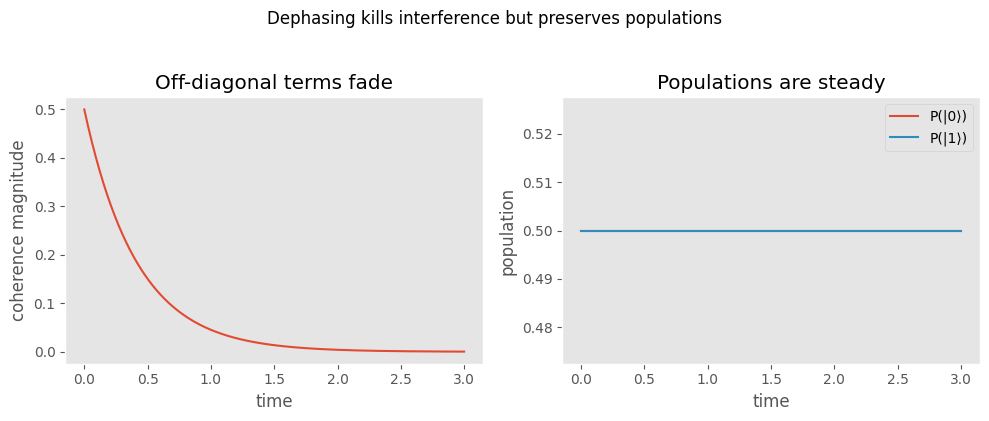

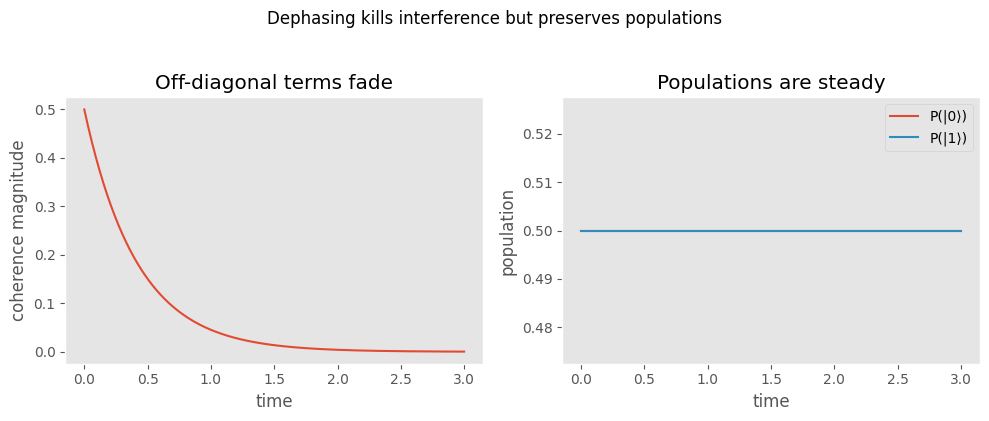

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(times, coherence, label=r"$|\rho_{01}|$")
axes[0].set_xlabel("time")
axes[0].set_ylabel("coherence magnitude")
axes[0].set_title("Off-diagonal terms fade")
axes[0].grid(False)

axes[1].plot(times, pop0, label="P(|0⟩)")
axes[1].plot(times, pop1, label="P(|1⟩)")
axes[1].set_xlabel("time")
axes[1].set_ylabel("population")
axes[1].set_title("Populations are steady")
axes[1].legend()
axes[1].grid(False)

fig.suptitle("Dephasing kills interference but preserves populations", y=1.04)
fig.tight_layout()
fig

The interference term $|\ho_{01}|$ decays exponentially while the diagonal populations remain equal. That is the signature of decoherence: the system is forced into a classical probability distribution without changing the underlying energy levels.

## 4. From interference to classical probabilities

We can probe the cat state with a $\sigma_x$ measurement, which distinguishes coherent superpositions. Initially the cat is **always** found in the `|+⟩` branch. As decoherence grows, the measurement becomes random.

In [5]:
plus = (ket0 + ket1) / np.sqrt(2)
minus = (ket0 - ket1) / np.sqrt(2)
effects_x = np.array([
    np.outer(plus, plus.conj()),
    np.outer(minus, minus.conj()),
])

initial_probs = density_matrix_probabilities(rho_cat, effects_x)
final_probs = density_matrix_probabilities(rho_evolution[-1], effects_x)
initial_probs, final_probs

(array([1., 0.]), array([0.50037329, 0.49962671]))

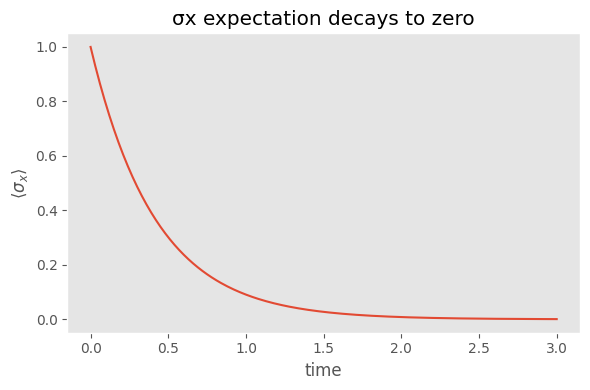

In [6]:
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
expectation_x = np.real(np.einsum("tij,ji->t", rho_evolution, sigma_x))

plt.figure(figsize=(6, 4))
plt.plot(times, expectation_x)
plt.xlabel("time")
plt.ylabel(r"$\langle \sigma_x \rangle$")
plt.title("σx expectation decays to zero")
plt.grid(False)
plt.tight_layout()
plt.show()

At $t=0$ the cat is definitely in the `|+⟩` branch ($\langle \sigma_x \rangle = 1$). By the time decoherence has acted, the expectation value sits near zero, signalling a classical mixture with equal weight in `|+⟩` and `|−⟩`.

## 5. Quantum trajectories (environment as sporadic “which-branch” probes)

The Lindblad equation can be unravelled into random `quantum jump` trajectories. Each trajectory represents a possible sequence of environment interactions. Averaging many trajectories reproduces the master equation.

In [7]:
traj_simulator = QuantumTrajectorySimulator(hamiltonian=hamiltonian, collapse_operators=collapse_ops)
ensemble = traj_simulator.ensemble_density_matrix(
    cat_state,
    times,
    trajectories=400,
    rng=np.random.default_rng(123),
)
ensemble_coherence = np.abs(ensemble[:, 0, 1])

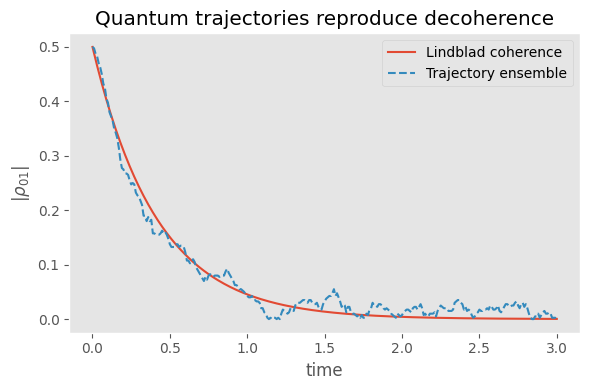

In [8]:
plt.figure(figsize=(6, 4))
plt.plot(times, coherence, label="Lindblad coherence")
plt.plot(times, ensemble_coherence, "--", label="Trajectory ensemble")
plt.xlabel("time")
plt.ylabel(r"$|\rho_{01}|$")
plt.title("Quantum trajectories reproduce decoherence")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

Each trajectory keeps the cat in a pure state, but stochastic phase kicks wash out the average coherence. The ensemble matches the Lindblad solution, so the decoherence story is fully present-time and operational.